In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Загрузка и первичный осмотр датасет

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

In [4]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [5]:
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path+'train.csv', encoding = 'ISO-8859-1', low_memory = False)
test = pd.read_csv(path+"test.csv", encoding = 'ISO-8859-1', low_memory = False)
submission = pd.read_csv(path+'sample_submission.csv', encoding = 'ISO-8859-1', low_memory = False)

## Описания полей

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредит

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


# Изучаем свойства признаков датасет train

### Признак app_date 

* Признак app_date - дата подачи заявки.
* Поле app_date представлено как объект, его превратим в числовой признак.

* Полное исследование признака показывает, что определенные влияние на целевой признак оказывает только месяц. остальные части даты вовсе не играют никакой роли для результата. Поэтому оставляем только значения месяца.В модели будем испытовать два варианта, категориальный и числовой.

In [8]:
# Поле app_date представлено как объект, его превратим в числовые признаки отдельно год, месяц, день 
for obj in [train, test]:
    dates = pd.to_datetime(obj.app_date, format="%d%b%Y")
    # obj['app_year'] = dates.dt.year
    obj['app_month'] = dates.dt.month
    # obj['app_day'] = dates.dt.day
    # obj['app_weekday'] = dates.dt.dayofweek
    # Рассчитываем  количества дней с самой ранней даты фиксации времени в dataset
    # obj['app_date_counts'] = obj['app_date'].apply(lambda x: (x - obj['app_date'].min()).days)
    obj = obj.drop(['app_date'], axis=1, inplace=True)

In [9]:
# Проверим, какие данные из датасета являются бинарными

for col in train.columns:
    if train[col].nunique() <= 2:
        print(col, " " * (20 - len(col)), train[col].nunique())

sex                   2
car                   2
car_type              2
good_work             2
foreign_passport      2
default               2


In [10]:
# Проверим, какие данные из датасета являются категориальными

for col in train.columns:
    if 2 < train[col].nunique() <= 5:
        print(col, " " * (20 - len(col)), train[col].nunique())

education             5
home_address          3
work_address          3
sna                   4
first_time            4
app_month             4


In [11]:
# Разделим предварительно наши данные на бинарные, категориальные и числовые. Делить будем на трейн сете, но это же разделение будет в будущем
# работать и на тестовых данных
def data_sort(data):
    bin_cols = list()
    cat_cols = list()
    num_cols = list()

    for col in data.drop(['client_id', 'default'], axis=1).columns:
        if data[col].nunique() <= 2:
            bin_cols.append(col)

        elif 2 < data[col].nunique() <= 5:
            cat_cols.append(col)

        elif data[col].nunique() > 5 and data[col].dtype in ["int64", "float64"]:
            num_cols.append(col)

    return bin_cols, cat_cols, num_cols

bin_cols, cat_cols, num_cols = data_sort(train)
bin_cols, cat_cols, num_cols

(['sex', 'car', 'car_type', 'good_work', 'foreign_passport'],
 ['education',
  'home_address',
  'work_address',
  'sna',
  'first_time',
  'app_month'],
 ['age',
  'decline_app_cnt',
  'score_bki',
  'bki_request_cnt',
  'region_rating',
  'income'])

# Изучение числовых признаков 

## Посмотрим на корреляцию числовых признаков датасета с целевой переменной

<AxesSubplot:>

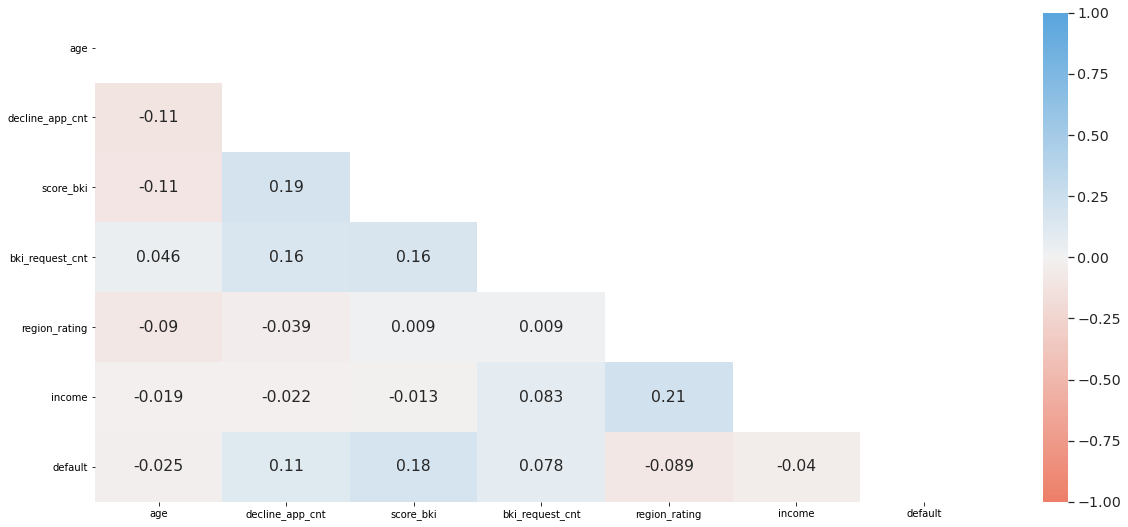

In [12]:
corrmat = train[num_cols + ["default"]].corr()

f, ax = plt.subplots(figsize=(20,9))

colormap =  sns.diverging_palette(20, 240, l=65, as_cmap=True)
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.3)
sns.heatmap(corrmat, mask=mask, vmax=1, vmin=-1, annot=True, center=0, cmap=colormap)

Выводы из таблицы. Корреляция признаков с default очень слабая, наиболее высокая корреляция наблюдается у признаков score_bki, и decline_app_cnt - 0.18 и 0.11 cоответственно. Оставим все признаки, т.к. сильной корреляции (>0.8) здесь нет.

## Изучаем распределения числовых признаков

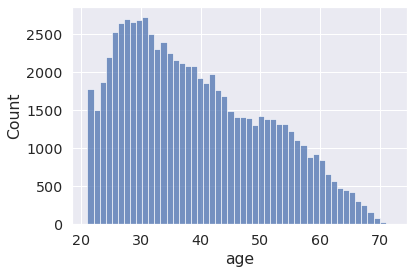

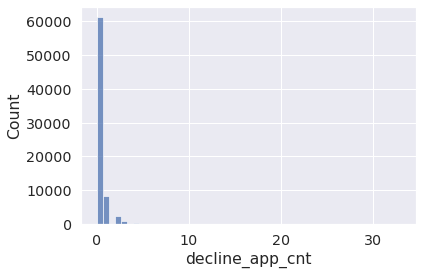

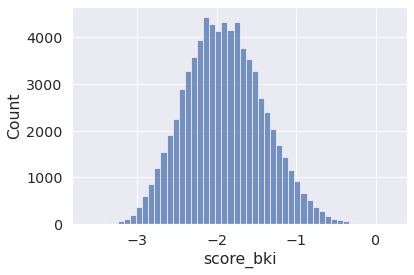

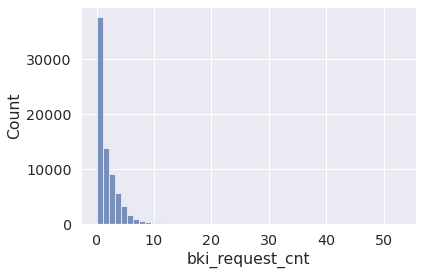

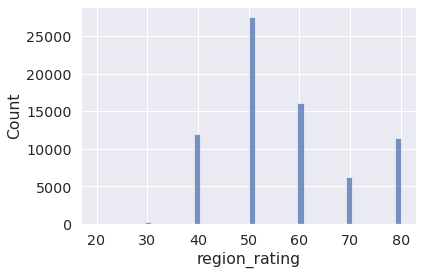

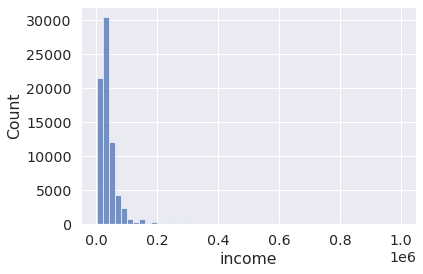

In [13]:
for col in num_cols:
    sns.histplot(train[col], cbar=True, bins = 50)
    plt.show()
    

Графикам значения score_bki   распределены более менее равномерно, по этому оставим как есть. Признаки age, income,  возможно должны быть прологарифмированы.

In [14]:
train[num_cols].describe()

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,39.280641,0.275749,-1.904724,2.000339,56.725701,41099.775417
std,11.520378,0.804272,0.498231,2.252073,13.055717,46166.322400
min,21.000000,0.000000,-3.624586,0.000000,20.000000,1000.000000
25%,30.000000,0.000000,-2.259534,0.000000,50.000000,20000.000000
50%,37.000000,0.000000,-1.920823,1.000000,50.000000,30000.000000
75%,48.000000,0.000000,-1.569831,3.000000,60.000000,48000.000000
max,72.000000,33.000000,0.199773,53.000000,80.000000,1000000.000000


## Изучаем связь числовых признаков с целевой

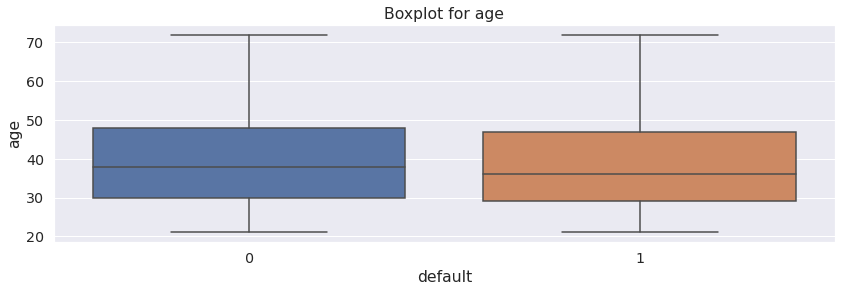

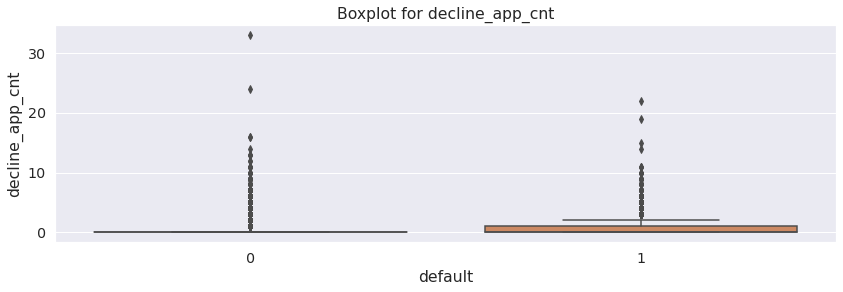

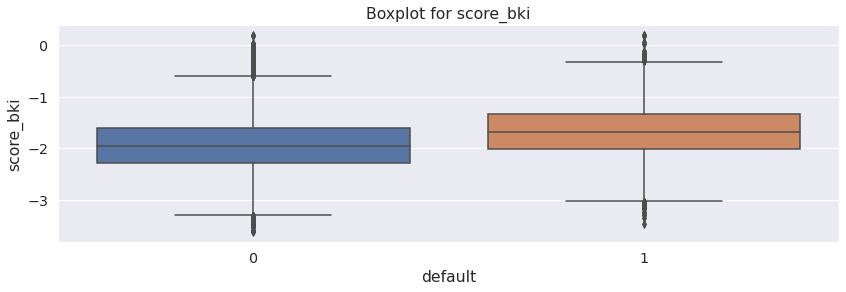

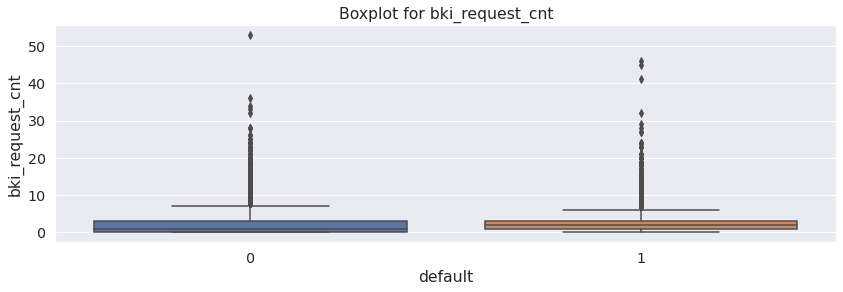

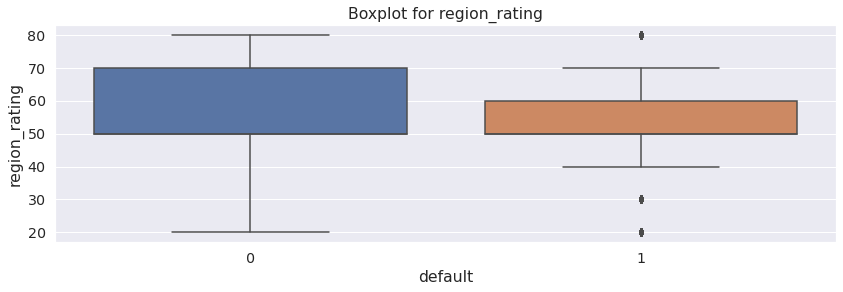

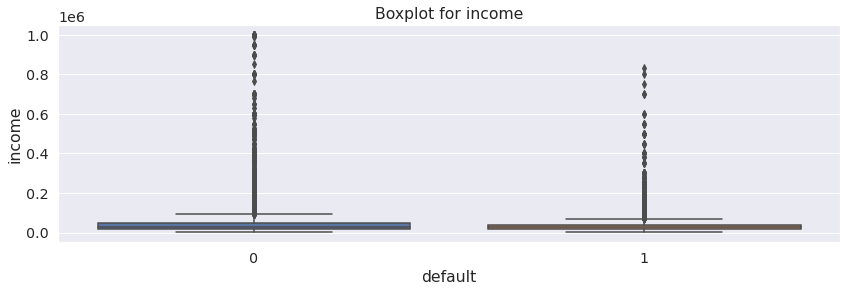

In [15]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=train, ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

Здесь видим, что старшие люди не допускают дефолт. Люди, которые допускают дефолт, имеют более высокий score_bki. Рейтинг региона влияет на значение дефолт. bki_request_cnt выше у людей, не допускающий дефолт. В среднем люди, которые не делают дефолта, имеют более высокий доход.

In [16]:
# Посмотрим на значимость числовых данных для нашей целевой переменной
num_weights = pd.Series(f_classif(train[num_cols], train['default'])[0], index=num_cols)
num_weights

age                  46.166168
decline_app_cnt     966.206975
score_bki          2341.599450
bki_request_cnt     454.555786
region_rating       589.678381
income              116.798014
dtype: float64

Как видно из данных наиболее значимым для целевой переменной 'default' является score_bki

### Изучаем выбросы для числовых признаков

In [17]:
for col in num_cols:
    median = train[col].median()
    IQR = train[col].quantile(0.75) - train[col].quantile(0.25)
    perc25 = train[col].quantile(0.25)
    perc75 = train[col].quantile(0.75)
    
    print("Column: ", col)
    print("Максимальное значение в данных:", train[col].max())
    print("Минимальное значение в данных:", train[col].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.259533835, 75%: -1.56983126, IQR: 0.6897025750000001,  Borderline: [-3.2940876975, -0.5352773974999998].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  Borderline: [-4.5, 7.5].

Column:  region_rating
Максимальное значение в данных: 80
Минимальное значение в данных: 20
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  Borderline: [-22000.0, 90000.0].



Больших  выбросов нет, поэтому удалять выбросов не будем.

In [18]:
# Определим соотношении значения целевого признака (default)
train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Соотношение default для 0 и 1 слишком большое (почти 6,9 раз). Возможно требуется рассмотреть вариант баланировки датасет. 

# Изучение категориальных признаков

In [19]:
cat_cols

['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_month']

## Распределение категориальных признаков

In [20]:
train['education'].value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [21]:
train['home_address'].value_counts()

2    39956
1    32585
3     1258
Name: home_address, dtype: int64

In [22]:
train['work_address'].value_counts()

3    44959
2    20506
1     8334
Name: work_address, dtype: int64

In [23]:
train['sna'].value_counts()

1    47301
4    11749
2    10626
3     4123
Name: sna, dtype: int64

In [24]:
train['first_time'].value_counts()

3    31255
4    18737
1    12239
2    11568
Name: first_time, dtype: int64

## Связь категориальных признаков с целевым признаком

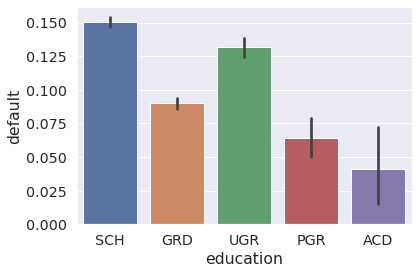

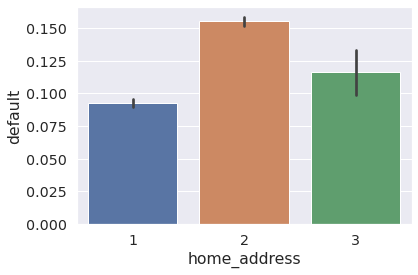

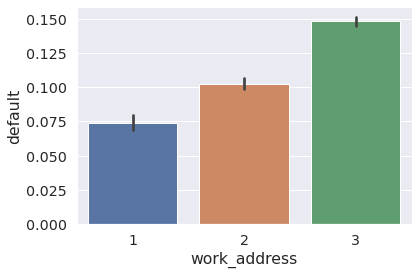

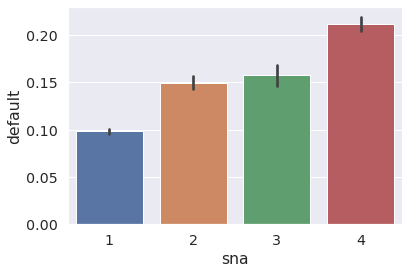

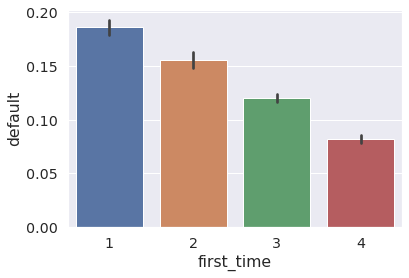

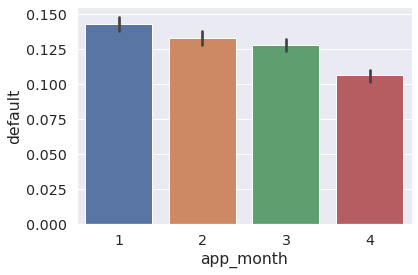

In [25]:
for col in cat_cols:
    sns.barplot(x=col, y="default", data=train[[col, 'default']])
    plt.show()

Категориальные признаки влияют на целевой по разному. Их преобразуем к dummy признаки.

# Изучение бинарных признаков

## Посмотрим соотношение бинарных признаков к целевой переменной

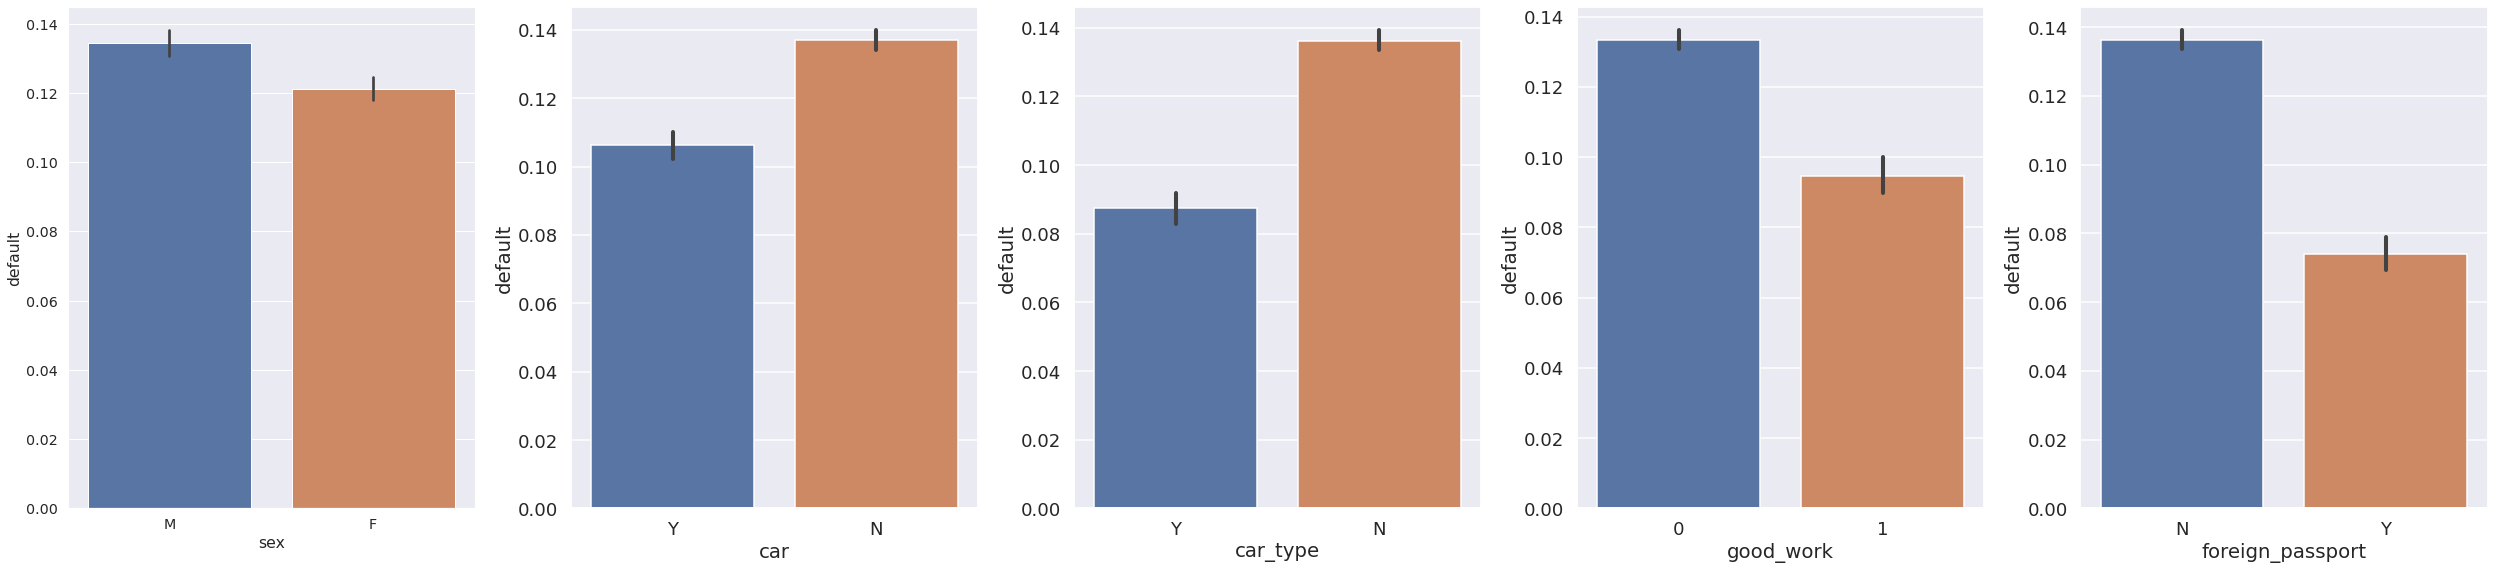

In [26]:
def features_relation(data_frame, columns):
    sns.set_style('darkgrid')
    
    fig = plt.figure(figsize=(35,10))
       
    for it, value in enumerate(columns):
        plt.subplot(1,len(columns),it+1)
        sns.barplot(x=value, y="default", data=data_frame[[value, 'default']])
        fig.tight_layout(pad=1.0)
        sns.set_context('talk',font_scale=1.1)
    
    fig.subplots_adjust(top=0.8)

features_relation(train, bin_cols)

Как видим из соотношения бинарных признаков к целевой переменной основную долю людей не возвращающих заём являются мужчины, люди без автомобиля, и люди не имеющие хорошей работы и загранпаспорта.

# Feature Engineering

In [27]:
# Объединим train и test, создадим единную базу data для того, чтобы совместно обработать признаков 
# и для ввода новых признаков и их преобразования в исходных датасетах

train['default_is'] = 1   
test['default_is'] = 0    
test['default'] = -1  
data = train.append(test, sort=False).reset_index(drop=True)

In [28]:
# Для обработки снимаем копию data
df = data.copy()

In [29]:
# Заполняем пропуски в колонке education
df.education.fillna("SCH", inplace=True)

# Логарифмируем доход и возраст    
df['income']= np.log(df['income'])
# df['age']= np.log(df['age'])  # Включение  признака ухудшает показатель roc_auc_score

In [30]:
# mean income by age
# mean_income = df.groupby('age')['income'].mean().to_dict()
# df['mean_income_age'] = df['age'].map(mean_income)

# Max income by age
# max_income = df.groupby('age')['income'].max().to_dict()
# df['max_income_age'] = df['age'].map(max_income)

# and normalize it
# df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)
# df["normalized_income"] = abs((df.income - df['age'].map(mean_income))/df['age'].map(max_income))

# requests to BKI by age
# mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
# df['mean_requests_age'] = df['age'].map(mean_bki)

# mean decline_app by income
# mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
# df['mean_requests_income'] = df['income'].map(mean_bki_inc)

# mean BKI requests by income
# mean_decline = df.groupby('income')['decline_app_cnt'].mean().to_dict()
# df['mean_decline_income'] = df['income'].map(mean_decline)


# Mean income by region
# mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
# df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

# df['income_age'] = df.income*df['age']
# df['income_region'] = df['region_rating']*df['income']

Включение вышеприведенных признаков ухудшает показатель roc_auc_score

In [31]:
# Разделим предварительно наши данные на бинарные, категориальные и числовые. 
# Это деление общие для датасеты train и test

def data_sort(data):
    bin_cols = list()
    cat_cols = list()
    num_cols = list()

    for col in data.drop(['client_id', 'default','default_is'], axis=1).columns:
        if data[col].nunique() <= 2:
            bin_cols.append(col)

        elif 2 < data[col].nunique() <= 5:
            cat_cols.append(col)

        elif data[col].nunique() > 5 and data[col].dtype in ["int64", "float64"]:
            num_cols.append(col)

    return bin_cols, cat_cols, num_cols

In [32]:
bin_cols, cat_cols, num_cols = data_sort(df)

In [33]:
# Переведем дату в катеогрию "численные", т.к. это влияет на метрики модели, чем как категориальный
cat_cols.remove('app_month')
num_cols.append('app_month')
# bin_cols, cat_cols, num_cols

In [34]:
cols = num_cols.copy()

## Добавим в датасеты train,test полиномы основных числовых признаков

In [35]:
# Формируем полиномиальные признаки из числовых
pf = PolynomialFeatures(degree=2)
new_data = pf.fit_transform(df[num_cols])[:, len(num_cols) + 1:]
pf_columns = pf.get_feature_names()[len(num_cols) + 1 :]

# добавляем новые полиномиальные значения к датасету
df = pd.concat([df, pd.DataFrame(new_data, columns=pf_columns)], axis=1)

# добавляем новые полиномиальные признаки к датасету
num_cols.extend(pf_columns)

# Нормализация признаков num_cols
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

df.shape

(110148, 48)

In [36]:
 # Преобразуем категориальных и бинарных признаков на числовые классификации
mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

mappc = {}
enc = OneHotEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))
mapp, mappc

({'sex': {0: 'F', 1: 'M'},
  'car': {0: 'N', 1: 'Y'},
  'car_type': {0: 'N', 1: 'Y'},
  'good_work': {0: 0, 1: 1},
  'foreign_passport': {0: 'N', 1: 'Y'}},
 {'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'},
  'home_address': {0: 1, 1: 2, 2: 3},
  'work_address': {0: 1, 1: 2, 2: 3},
  'sna': {0: 1, 1: 2, 2: 3, 3: 4},
  'first_time': {0: 1, 1: 2, 2: 3, 3: 4}})

In [37]:
# Создаем и добавим в датасет новые dummy переменные для категориальных признаков
dataset = df.copy()
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols)

In [38]:
df.shape

(110148, 62)

## Посмотрим влияние признаков на целевую

In [39]:
data_temp = dataset.loc[data['default_is'] == 1] 

<AxesSubplot:>

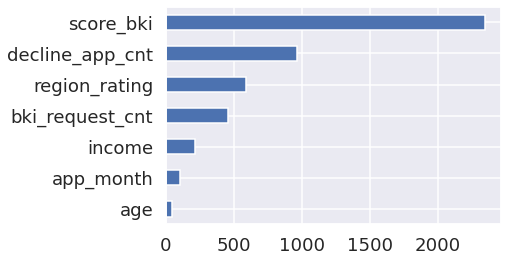

In [40]:
# Анализируем основные числовые признаки (без полиномальных)
imp_num = pd.Series(f_classif(data_temp[cols], data_temp['default'])[0], index = cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

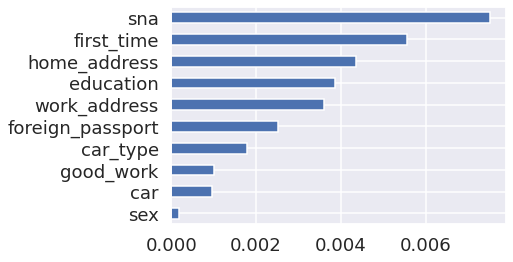

In [41]:
# Анализируем категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], 
             data_temp['default'], discrete_features =True), 
             index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Моделирование 

In [42]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [43]:
# Выделение подготовленные датасеты для обучения и тестирования
train_df = df.query('default_is == 1').drop(['default_is','client_id'], axis=1)
test_df = df.query('default_is == 0').drop(['default_is','client_id'], axis=1)

# Выделим целевую переменную из train датасета
X = train_df.drop(['default'], axis=1).values
Y = train_df['default'].values 

In [44]:
# Функция для обучения с помощиью модели LogisticRegression с использованием GridSearchCV
def predict_engine():
    # Создадим гиперпараметры. 
    # hyperparameters = dict(C=[0.01, 0.1, 1], penalty=['l1','l2'])
    hyperparameters = dict(C=[0.01], penalty=['l2'])
    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_SEED)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    return GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# Функция оценки качества работы модели
def model_scoring(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('ROC AUC SCORE = %0.5f' % roc_auc_score(y_test, probs))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')

# Функция печати метрик модели
def print_rez():
    print('accuracy_score:',accuracy_score(Y_test,Y_pred))
    print('precision_score:',precision_score(Y_test,Y_pred))
    print('recall_score:',recall_score(Y_test,Y_pred))
    print('f1_score:',f1_score(Y_test,Y_pred))
    print('MSE: {}'.format(np.round(mean_squared_error(Y_test, Y_pred), 4)))
    
# Просмотр результата тренировки модели спомощью Confusion Matrix
def conf_matrix():
    conf_mat = confusion_matrix(Y_test, Y_pred)
    sns.set(font_scale=1.4) 
    sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap=colormap)

Обучим модель на train_df сете, предварительно разделив его  для использования метрик. Это разделение и обучение используется исключительно для приблизительного замера модели с помощью roc_auc_score и сonfusion matrix. Для итогового результата train_df датасет делить не будем

In [45]:
# Подготовка данных для модели
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

## Обучения с помощиью модели LogisticRegression и GridSearchCV

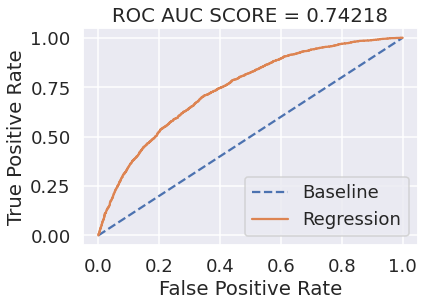

In [46]:
# Обучение модели
clf = predict_engine()
clf.fit(X_train, Y_train)
probs = clf.predict_proba(X_test)[:, 1]
Y_pred = clf.predict(X_test)

model_scoring(Y_test, probs)

In [47]:
# clf.best_params_

In [48]:
print_rez()

accuracy_score: 0.8752032520325204
precision_score: 0.3972602739726027
recall_score: 0.015873015873015872
f1_score: 0.030526315789473683
MSE: 0.1248


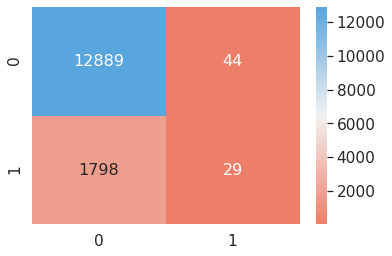

In [49]:
# Посмотрим на результат тренировки модели спомощью Confusion Matrix
conf_matrix()

In [50]:
# Теперь создадим новую модель и обучим ее на полном train датасете
clf.fit(X, Y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01], 'penalty': ['l2']})

In [51]:
# Предсказание на тестовой модели и подготовка данных для Leaderboard
test_df = df.query('default == -1').drop(['client_id', 'default_is', 'default'], axis=1)
test['default'] = clf.predict_proba(test_df)[:, 1]
test[['client_id', 'default']].head()

,client_id,default
0,74835,0.039952
1,17527,0.366893
2,75683,0.065665
3,26883,0.079200
4,28862,0.025577


### Балансировка датасет train 

* Выберем случайным образом из train_df['default']==0 такое количество строк, которое
* равнялось бы train['default']==1, и затем объединим с train_df['default']==1.

In [52]:
df_1 = df.query('default_is == 1').drop(['default_is','client_id'], axis=1)

under_train = pd.concat([df_1[df_1['default']==0].sample(
    len(df_1[df_1['default']==1]), random_state=RANDOM_SEED), df_1[df_1['default']==1]])

X_1 = under_train.drop(columns = ['default'])
Y_1 = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y_1,  test_size=0.2, random_state = RANDOM_SEED)

### Обучение модели с поомощью балансированного датасета 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.2s finished


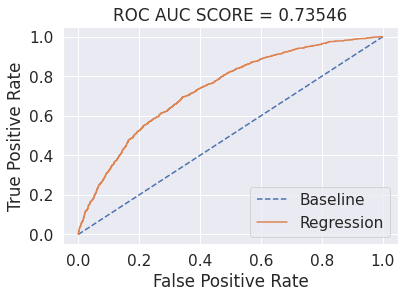

In [53]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_SEED)

hyperparameters = dict(C=[0.01, 0.1, 1], max_iter=[1000],penalty=['l1','l2'])
# hyperparameters = dict(C=np.linspace(0, 100, 5),max_iter=[1500], penalty=['l1','l2'])

# params = {'C': [0.01, 0.1, 1], 'max_iter': 1000}

lr_bal = GridSearchCV(lr, hyperparameters, verbose=1, cv=5)

lr_bal.fit(X_train, Y_train)
probs = lr_bal.predict_proba(X_test)
Y_pred = lr_bal.predict(X_test)
probs = probs[:,1]

model_scoring(Y_test, probs)

In [54]:
print("Лучшие параметры модели: ", lr_bal.best_params_)

Лучшие параметры модели:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}


In [55]:
print_rez()

accuracy_score: 0.675113363563617
precision_score: 0.6668393782383419
recall_score: 0.6911922663802363
f1_score: 0.6787974683544303
MSE: 0.3249


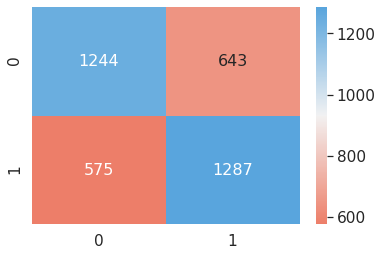

In [56]:
# Посмотрим на результат тренировки модели спомощью Confusion Matrix
conf_matrix()

In [57]:
# предсказание на тестовой модели и подготовка данных для Leaderboard
test_df = df.query('default == -1').drop(['client_id', 'default_is', 'default'], axis=1)
test['default'] = lr_bal.predict_proba(test_df)[:, 1]
test[['client_id', 'default']].head()

,client_id,default
0,74835,0.216085
1,17527,0.764922
2,75683,0.316088
3,26883,0.377780
4,28862,0.154296


## Используем модель CatBoostClassifier

С балансированным датасетом для модели LogisticRegression попробуем ипользовать модель CatBoostClassifier

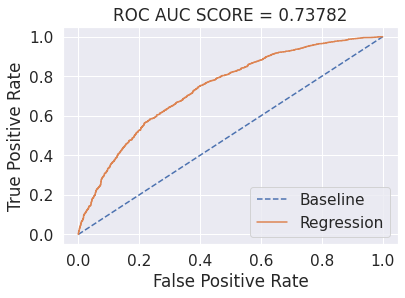

In [58]:
cat = CatBoostClassifier(n_estimators=1000,
                         depth=2,
                         logging_level='Silent')

cat.fit(X_train, Y_train)
probs = cat.predict_proba(X_test)
Y_pred = cat.predict(X_test)
probs = probs[:,1]

model_scoring(Y_test,probs)

In [59]:
print_rez()

accuracy_score: 0.6703120832221926
precision_score: 0.661340206185567
recall_score: 0.6890440386680988
f1_score: 0.6749079431877959
MSE: 0.3297


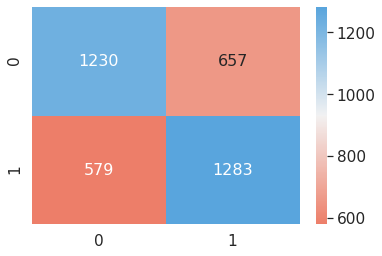

In [60]:
# Посмотрим на результат тренировки модели спомощью Confusion Matrix
conf_matrix()

In [61]:
# предсказание на тестовой модели и подготовка данных для Leaderboard
test_df = df.query('default == -1').drop(['client_id', 'default_is', 'default'], axis=1)
test['default'] = cat.predict_proba(test_df)[:, 1]
test[['client_id', 'default']].head()

,client_id,default
0,74835,0.204371
1,17527,0.731473
2,75683,0.381614
3,26883,0.392154
4,28862,0.113634


## Использовуем модель CatBoostClassifier для полного набора датасет train

In [62]:
# Подготовка данных для модели
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                    test_size=0.2, random_state=RANDOM_SEED)

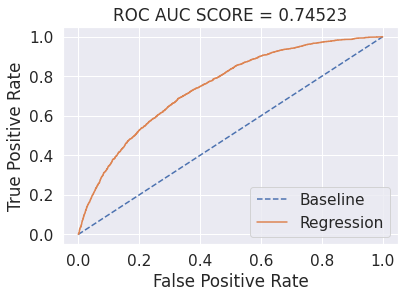

In [63]:
cat_pull = CatBoostClassifier(n_estimators=1500,
                         depth=2,
                         logging_level='Silent')

cat_pull.fit(X_train, Y_train)
probs = cat_pull.predict_proba(X_test)
Y_pred = cat_pull.predict(X_test)
probs = probs[:,1]

model_scoring(Y_test,probs)

In [64]:
print_rez()

accuracy_score: 0.8754065040650406
precision_score: 0.43333333333333335
recall_score: 0.021346469622331693
f1_score: 0.04068857589984352
MSE: 0.1246


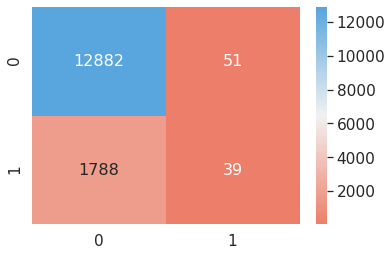

In [65]:
# Посмотрим на результат тренировки модели спомощью Confusion Matrix
conf_matrix()

In [66]:
# предскажем данные на тестовой модели и подготовим данные для Leaderboard
test_df = df.query('default_is == 0').drop(['client_id', 'default_is','default'], axis=1)

test['default'] = cat_pull.predict_proba(test_df)[:, 1]
test[['client_id', 'default']].head()

,client_id,default
0,74835,0.039047
1,17527,0.294303
2,75683,0.076218
3,26883,0.077174
4,28862,0.019470


In [67]:
submission = test[['client_id', 'default']]
submission.to_csv("submission.csv", index=False)

Результаты стали лучше, чем были в модели логистической регресии с гиперпараметрами, поэтому для submission будет использована модель CatBoostingClassifier
